#### Questions to ask
 - Feature scaling to train and test, sperately or together
 - Same question for word vectorizers

#### Next Steps

 - Check the random model accuracy more closely, compare them with regularized models, understand what's happening to the weights in L1 and L2
 - try an SVM regression or something else
 - Understand all your features, gather more domain knowledge
 
Checks
 - Go back to the different cities notebook and make sure everything is fine, particularly the splitting and joining back of dataframes
 - check that the train test split is doing it right (according to time stamp)
 
Feature Engineering and Selection
 - Consolidate the climate features into some form common metric OR
 - EDA on features, check correlation amongst features and y labels, take the most important ones
 
Later
 - Use imputation for null values

#### Results from Experiments
 - Directly using week number as a feature didn't do good, so we engineered the month and it did better
 - Surprisingly the month when one hot encoded does worse than otherwise
 - adding the city boolean has done a good improvement to the model
 - Both L1 and L2 seem to improve the model 
 - Hyperparameter tuning has led to some dramatic improvements in accuracy

#### importing the relevant packages and loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

X = pd.read_csv("dengue_features_train.csv")
y = pd.read_csv("dengue_labels_train.csv")
test = pd.read_csv("dengue_features_test.csv")

#### Data Preprocessing

In [2]:
# Converting the city column into a boolean, since we just have two cities
# To be used later
is_sj = X.city == 'sj'

In [3]:
def extract_month(s):
    return int(s[5:7])

months = X.week_start_date.apply(extract_month)

In [4]:
# Removing the dates info for now
X.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)

#### Train Test Split
We shall split our dataset based on time stamps as we are required to make predictions for the future.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [6]:
# Dropping the rows with null values for now
X.dropna(inplace=True)
# Selecting y values corresponding to the filtered X values
y = y.total_cases.loc[X.index]

# Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

In [7]:
X['is_sj'] = is_sj.loc[X.index]

In [8]:
# Month one hot features

sliced_months = months.loc[X.index]
month_features = pd.get_dummies(sliced_months)
X = X.join(month_features)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, shuffle = False)

#### Baseline Model

In [10]:
lr = LinearRegression()

lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

In [11]:
from sklearn.metrics import mean_absolute_error

def mape(Y_test, Y_pred, epsilon = 1):
    return np.mean(np.abs((Y_test - Y_pred + epsilon) / (Y_test + epsilon))) * 100

In [15]:
mean_absolute_error(Y_test, Y_pred)

12.635846111002717

In [16]:
mape(Y_test, Y_pred)

251.79890294960933

#### Random Model

In [12]:
y_p = np.full(len(Y_test), np.mean(Y_train))

In [13]:
mean_absolute_error(Y_test, y_p)

18.120148312940305

In [14]:
mape(Y_test, y_p)

436.48118768988996

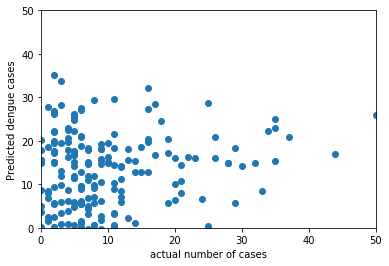

In [16]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

### Regularization

#### L2

In [136]:
from sklearn import linear_model

In [143]:
clf = linear_model.Ridge(alpha = 400)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

8.813269320382481

In [144]:
mape(Y_test, Y_pred, 10)

44.073486099477925

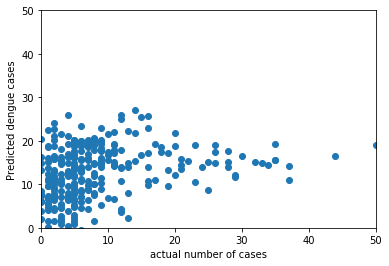

In [145]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### L1

In [140]:
clf = linear_model.Lasso(alpha=12)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

18.120148312940305

In [141]:
mape(Y_test, Y_pred, 21)

16.274043985391003

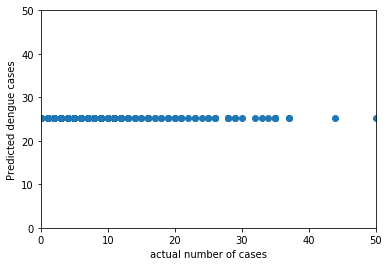

In [142]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### hyperparameter tuning stage

In [94]:
L1 = {}

for a in range(1, 100):
    for l in range(15,25):
        clf = linear_model.Lasso(alpha=a)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        L1[a,l] = mape(Y_test, Y_pred, l)